In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix, accuracy_score,f1_score,precision_score, recall_score,roc_curve, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input,Bidirectional,SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping

# Disaster Tweets Detection

## Overview

- The data set is downloaded from the Kaggle Competition Natural Language Processing with Disaster Tweets. This is a binary classification problem. The tweets are either about real disasters or not.

- The goal of the project is to build a deep learning recurrent model to predict if a tweet is about a real disaster.

- The training data set includes short parts of tweets and their label (0: not disaster, 1: disaster).

## EDA

### Import data

Let's import the training and test data.

In [4]:
# Import train data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

### Inspect data

The train data have 7613 different tweets. the text column stores the tweet content and target stores the label.

Other columns include id, keywords, and location. For this problem, I will ignore these columns and only try to classify tweets by their content.

In [10]:
# Inspect the data
train_df.info()
print("Training data set size: ",train_df.shape[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
Training data set size:  7613


In [11]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [14]:
#Check for duplicated text
print(train_df['text'].duplicated().sum())

#Remove duplicated data
train_df=train_df[-train_df['text'].duplicated()]
train_df.shape

110


(7503, 5)

There are 110 duplicated tweets so I removed them.

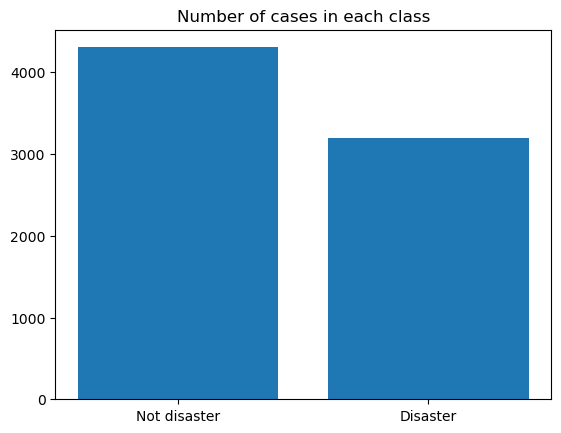

In [15]:
# Number of tweets in each class
Neg_num=sum(train_df['target']==0)
Pos_num=sum(train_df['target']==1)

x = np.array(["Not disaster", "Disaster"])
y = np.array([Neg_num, Pos_num])

plt.bar(x,y)
plt.title("Number of cases in each class")
plt.show()

The number of disaster tweets is lower than non disaster. This might introduce class imbalance problem to our model. Hopefully, the large number of tweets can minimize the effect of class imbalance.

### Preprocess data

By inspecting the tweets, I notice that there are a lot of special characters and links. This needs to be removed before fitting the models.

The following steps are taken to preprocess text data:
- Change all text to lowercase
- Remove any line breaks
- Remove url links
- Remove any special characters and numbers
- Remove stop words like 'I', 'and', 'the'...
- Leminize words (Eg. Burning, Burns -> Burn; Changing, Changes, Changed -> Change)

Let's looks at how the text changes after preprocessing.

In [117]:
#Preprocessing texts
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

def preprocess_text(text):
    text= text.lower() #Change texts to lower space
    text= re.sub(r'\n', '', text) # Remove line break 
    text = re.sub(r"http\S+","", text) # Remove links
    text= re.sub('[^A-Za-z ]+', ' ', text) # Remove any special characters and numbers
    text = text.split()
    text = [word for word in text if not word in nltk.corpus.stopwords.words("english")] #Remove any stop words in English
    leminizer = nltk.WordNetLemmatizer()
    text = [leminizer.lemmatize(word) for word in text] # leminize the words in english
    filtered_text = ' '.join(text)
    return filtered_text

train_df['filtered_text']=[preprocess_text(text) for text in train_df['text']]
test_df['filtered_text']=[preprocess_text(text) for text in test_df['text']]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marktran21/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/marktran21/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/marktran21/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [68]:
# Check the word filtering
print(train_df[['text','filtered_text']].head())

                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                       filtered_text  
0         deed reason earthquake may allah forgive u  
1              forest fire near la ronge sask canada  
2  resident asked shelter place notified officer ...  
3  people receive wildfire evacuation order calif...  
4  got sent photo ruby alaska smoke wildfire pour...  


After preprocessing the text, tweets are more concise and only important words remains.

### Visualize data

Let's find the length of tweets in each class after preprocessing. We want to make sure that the length of tweets is the same in both classes.

In [70]:
# Find word count for each class
train_df['wordcount'] = train_df.text.apply(lambda x: len(x.split()))
train_df[['target', 'wordcount']].groupby('target').describe()

wordcount                                                  
           count       mean       std  min   25%   50%   75%   max
target                                                            
0         4305.0  14.681069  6.159835  1.0  10.0  15.0  19.0  31.0
1         3198.0  15.140400  5.096809  2.0  11.0  15.0  19.0  30.0

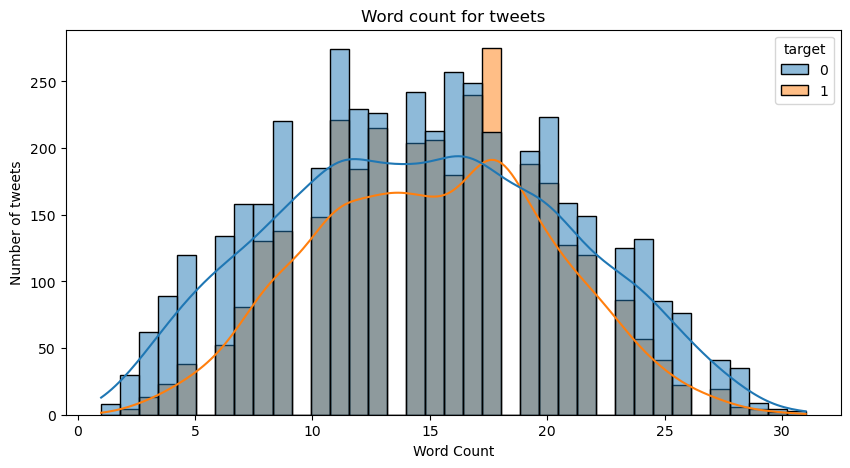

In [72]:
#Plot word count for each class
plt.figure(figsize=(10, 5))

sns.histplot(train_df, x='wordcount', hue='target',kde=True)
plt.xlabel('Word Count')
plt.ylabel('Number of tweets')
plt.title("Word count for tweets")
plt.show()

The length of tweets are the same in both classes with mean around 15 words. This is good because it shows that word length wouldn't play a role in predicting label.

Let's see what words are the most common in each class.

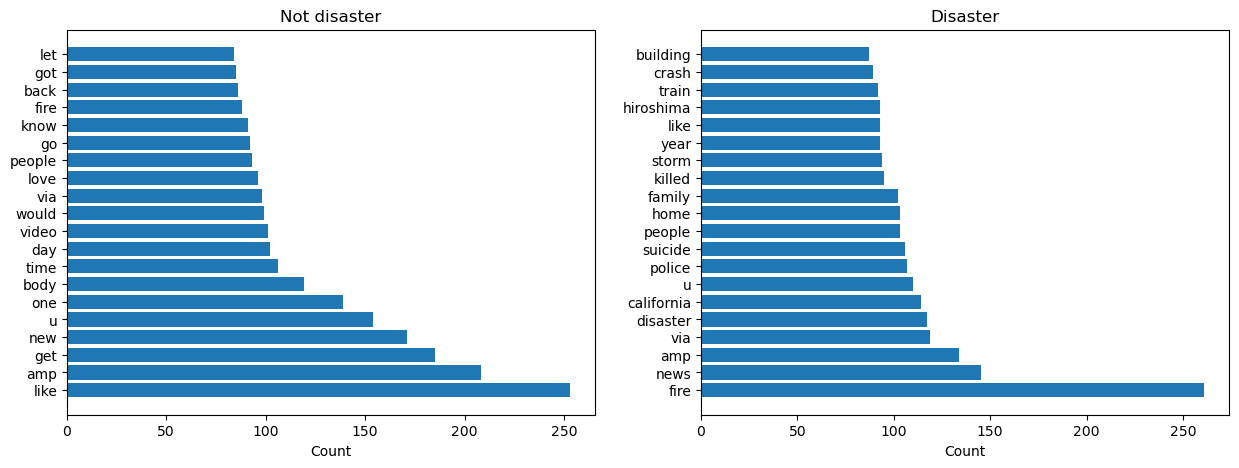

In [112]:
# Most common words in each class
from collections import Counter
neg_words=sum([text.split() for text in train_df[train_df['target']==0]['filtered_text']],[])
pos_words=sum([text.split() for text in train_df[train_df['target']==1]['filtered_text']],[])

neg_common_elements = Counter(neg_words).most_common(20)
pos_common_elements = Counter(pos_words).most_common(20)

#Plot 20 most common words
fig = plt.figure(figsize = (15, 5))

x = np.array([neg_common_elements[i][0] for i in range(0,20)])
y = np.array([neg_common_elements[i][1] for i in range(0,20)])
plt.subplot(1, 2, 1)
plt.barh(x, y)
plt.xlabel("Count")
plt.title("Not disaster")

x = np.array([pos_common_elements[i][0] for i in range(0,20)])
y = np.array([pos_common_elements[i][1] for i in range(0,20)])
plt.subplot(1, 2, 2)
plt.barh(x, y)
plt.xlabel("Count")
plt.title("Disaster")

plt.show()


The most commons words in non disaster tweets vary and don't have a common theme. However, we can see that the disaster tweets have a clear theme and make sense.

### Tokenize text

Machine learning models only take input as numbers. Therefore, we have to encode the words to number. This process is called tokenizing text. Through this process, each word is represented by a different number.

I use TensorFlow tokenizer function which create a dictionary encoding different words encountered in the training data set to numbers. After that, I use this dictionary to translate tweets to number representation.

I also use padding to the tweets to make sure that all tweets have the same length. The previous word count inspection showed that the maximum of words in tweets is 30. Therefore, I add padding so that all tweets have the same length of 30 variables.

In [118]:
# Tokenize texts
#Create a Tokenizer with training text
tokenizer = Tokenizer(num_words=10000, oov_token=True, lower= True)
tokenizer.fit_on_texts(train_df['filtered_text'])

#Create sequences of tokenized words
training_sequences = tokenizer.texts_to_sequences(train_df['filtered_text'])
training_sequences = pad_sequences(training_sequences, maxlen=30)

testing_sequences = tokenizer.texts_to_sequences(test_df['filtered_text'])
testing_sequences = pad_sequences(testing_sequences, maxlen=30)

### Split training and validation

I split the training data set into training and validation set. The validation set has 25% of the original data set. I use stratified split so that the ratio between 2 classes stay the same in the training and validation set.

We are now ready to train models.

In [139]:
#Reset the index of training data frame
train_df=train_df.reset_index()

# Split training and validation set
splitter = StratifiedShuffleSplit(n_splits=2, test_size=0.25, random_state=1)
train_index, val_index = next(splitter.split(training_sequences, train_df['target']))

X_train = training_sequences[train_index]
y_train = np.array(train_df['target'][train_index])
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))

X_val = training_sequences[val_index]
y_val = np.array(train_df['target'][val_index])
y_val = np.asarray(y_val).astype('float32').reshape((-1,1))

## Simple RNN Model

### Building Model

I choose to build a simple Recurrent Neural Network (CNN) because of its effeciency in proccessing sequential data like texts.

My RNN model has 3 layers:
- Embedding: this layer transforms the number representation of words into vectors with 128 dimensions. This process helps group words that associated with disaster together in the dimensions.
- Simple RNN: this layer takes the sequence of 30 words and their 128 dimensions and update weights to return the last output. After that, I add a drop out layer with masking rate of 0.25. This would randomly change weights of 25% of the last layer to 0. The drop out layer will help reduce overfitting risk.
- Output layer: This is a fully connected layer with the sigmoid activation function giving the probability that the tweet is disaster.


In [224]:
# Simple RNN model

model_RNN = Sequential([
    Embedding(input_dim = 10000, output_dim = 128,input_length=30),
    Bidirectional(SimpleRNN(128, return_sequences=False)),
    Dropout(0.25),
    Dense(1, activation='sigmoid')])

#Summary
model_RNN.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 30, 128)           1280000   
                                                                 
 bidirectional_11 (Bidirecti  (None, 256)              65792     
 onal)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 257       
                                                                 
Total params: 1,346,049
Trainable params: 1,346,049
Non-trainable params: 0
_________________________________________________________________


### Training Model

I decide to optimize the model using adam optimizer with initial learning rate of 0.0001. Adam optimizer will help the model converge faster because it is an adaptive learning rate optimizer.

The loss function is selected to be binary cross entropy. This is appropriate for my data because it's a binary classification problem. 

I also use early stopping for my model. My model would stop the epoch when the validation loss doesn't decrease significantly after 3 epoch. After stopping, the model will use the weights from the previous best epoch. I decide to use early stopping because this is a large data set to train and my computater capacity isn't great. Early stopping also prevent the model from overfitting.

Now let's train the model.

In [232]:
# Compile the model
model_RNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Early stopping
ES = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Batch_size=32

# Train the model
history_RNN = model_RNN.fit(
    X_train,
    y_train,
    batch_size=Batch_size,
    steps_per_epoch=X_train.shape[0] // Batch_size,
    validation_data=(X_val,y_val),
    epochs=10,
    callbacks=[ES])


Epoch 1/10
175/175 [==============================] - 22s 71ms/step - loss: 0.0595 - accuracy: 0.9823 - val_loss: 0.8278 - val_accuracy: 0.7324
Epoch 2/10
175/175 [==============================] - 8s 44ms/step - loss: 0.0447 - accuracy: 0.9836 - val_loss: 0.8123 - val_accuracy: 0.7292
Epoch 3/10
175/175 [==============================] - 10s 57ms/step - loss: 0.0476 - accuracy: 0.9836 - val_loss: 0.8427 - val_accuracy: 0.7175
Epoch 4/10
175/175 [==============================] - 10s 55ms/step - loss: 0.0370 - accuracy: 0.9845 - val_loss: 0.7854 - val_accuracy: 0.7415
Epoch 5/10
175/175 [==============================] - 8s 45ms/step - loss: 0.0357 - accuracy: 0.9855 - val_loss: 0.9223 - val_accuracy: 0.6748
Epoch 6/10
175/175 [==============================] - 9s 50ms/step - loss: 0.0345 - accuracy: 0.9853 - val_loss: 0.9073 - val_accuracy: 0.7020
Epoch 7/10
175/175 [==============================] - 9s 53ms/step - loss: 0.0373 - accuracy: 0.9841 - val_loss: 0.9009 - val_accuracy: 0.6

### Results

The model stops its training after 7 epoch. We can see that the validation loss stops increasing after the epoch 4. Therefore, early stopping helps save training time and prevent overfitting.

The model training and validation accuracy are not bad. The losses are also low.

Let's plot and see how the model performs after each epoch.

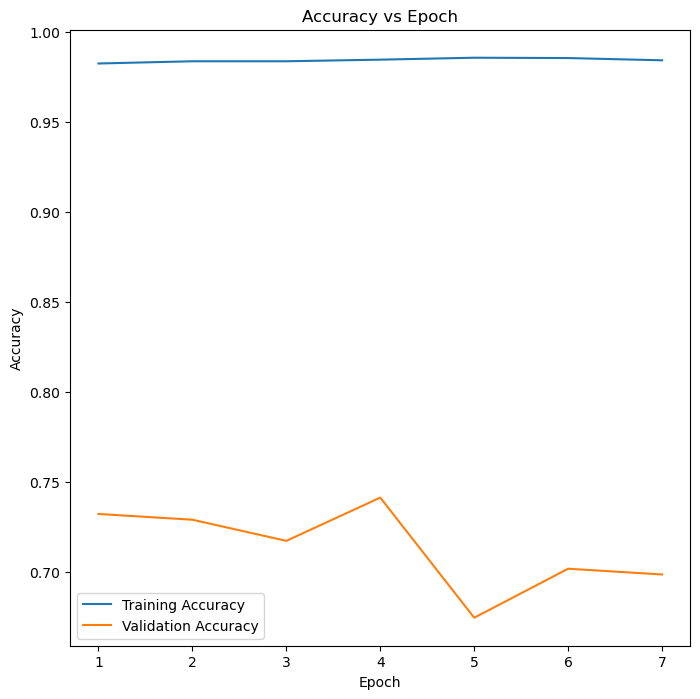

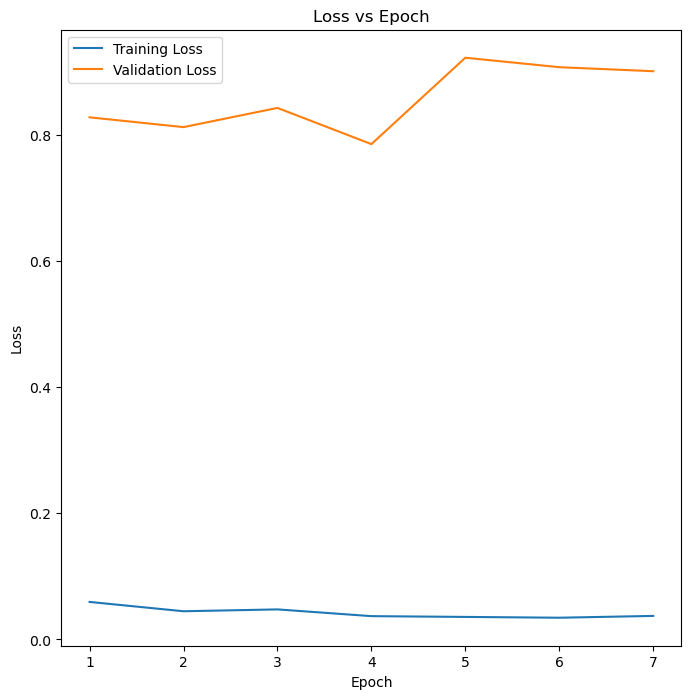

In [258]:
#Plot accuracy vs epoch
train_acc = history_RNN.history['accuracy']
val_acc = history_RNN.history['val_accuracy']
epoch_=[1,2,3,4,5,6,7]

plt.figure(figsize=(8, 8))
plt.plot(epoch_,train_acc, label="Training Accuracy")
plt.plot(epoch_,val_acc, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

#Plot loss vs epoch
train_loss = history_RNN.history['loss']
val_loss = history_RNN.history['val_loss']

plt.figure(figsize=(8, 8))
plt.plot(epoch_,train_loss, label="Training Loss")
plt.plot(epoch_,val_loss, label="Validation Loss")
plt.legend()
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

We see that the model increases its training and validation accuracy until the epoch 4. However, at the 5th epoch, the validation accuracy starts decreasing while the training accuracy still increases. The validation loss increases from 4th to 5th epoch. This suggests that the model has converged and have a risk of overfitting if it continues to be trained.

Therefore, the model converges at the 4th epoch and being stopped at epoch 7. The best weights from the 4th epoch is then restored.


59/59 [==============================] - 1s 8ms/step


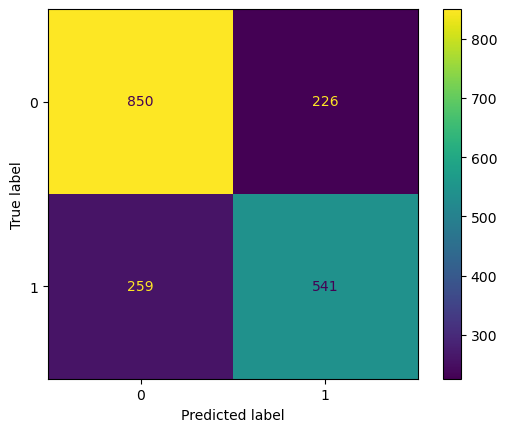

In [233]:
#Predict the test set
y_pred_RNN=model_RNN.predict(X_val)
y_pred_RNN=(y_pred_RNN > 0.5).astype(int).flatten()

#Confusion matrix
cm=confusion_matrix(y_val.flatten(),y_pred_RNN)
ConfusionMatrixDisplay(cm).plot()

In [235]:
# Accuracy metrics
acc_RNN=accuracy_score(y_val.flatten(),y_pred_RNN)
recall_RNN=recall_score(y_val.flatten(),y_pred_RNN)
precision_RNN=precision_score(y_val.flatten(),y_pred_RNN)
f1_RNN=f1_score(y_val.flatten(),y_pred_RNN)

print('Accuracy = '+"{:.3f}".format(acc_RNN))
print('Recall = '+"{:.3f}".format(recall_RNN))
print('Precision = '+"{:.3f}".format(precision_RNN))
print('f1 = '+"{:.3f}".format(f1_RNN))

Accuracy = 0.741
Recall = 0.676
Precision = 0.705
f1 = 0.690


The model validation accuracy is 0.741. The model misclassifies both labels at around the similar number. This is reflected in the f1 score of 0.69. 

Let's see if we can improve the performance with the next model.

## Long Short Term Memory Model (LSTM)

### Building Model

LSTM is supposed to be an improvement from simple RNN model thanks to its abaility to retain both long and short term memory.  It also reduces the risk of vanishing/ exploding gradient faced by simple RNN.

My LSTM also has 3 major layers:
- Embedding
- LSTM and Drop out (0.25)
- Output layer



In [228]:
# LSTM model
model_LSTM = Sequential([
    Embedding(input_dim = 10000, output_dim = 128,input_length=30),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.25),
    Dense(1, activation='sigmoid')])

#Summary
model_LSTM.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 30, 128)           1280000   
                                                                 
 bidirectional_12 (Bidirecti  (None, 256)              263168    
 onal)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 1)                 257       
                                                                 
Total params: 1,543,425
Trainable params: 1,543,425
Non-trainable params: 0
_________________________________________________________________


### Training model

The model also trains using Adam optimizer and binary cross entropy loss. I also implement early stopping after 3 epochs.

In [236]:
# Compile the model
model_LSTM.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Early stopping
ES = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Batch_size=32

# Train the model
history_LSTM = model_LSTM.fit(
    X_train,
    y_train,
    batch_size=Batch_size,
    steps_per_epoch=X_train.shape[0] // Batch_size,
    validation_data=(X_val,y_val),
    epochs=10,
    callbacks=[ES])

Epoch 1/10
175/175 [==============================] - 32s 156ms/step - loss: 0.0397 - accuracy: 0.9827 - val_loss: 1.4316 - val_accuracy: 0.7681
Epoch 2/10
175/175 [==============================] - 27s 153ms/step - loss: 0.0322 - accuracy: 0.9841 - val_loss: 1.4701 - val_accuracy: 0.7527
Epoch 3/10
175/175 [==============================] - 29s 166ms/step - loss: 0.0326 - accuracy: 0.9832 - val_loss: 1.2124 - val_accuracy: 0.7676
Epoch 4/10
175/175 [==============================] - 27s 154ms/step - loss: 0.0294 - accuracy: 0.9846 - val_loss: 1.5621 - val_accuracy: 0.7660
Epoch 5/10
175/175 [==============================] - 25s 145ms/step - loss: 0.0238 - accuracy: 0.9880 - val_loss: 1.6812 - val_accuracy: 0.7601
Epoch 6/10
175/175 [==============================] - 25s 142ms/step - loss: 0.0282 - accuracy: 0.9848 - val_loss: 1.6205 - val_accuracy: 0.7575


### Results

The model stops training at epoch 6. We can see that the validation loss stops increasing after the epoch 3. Therefore, early stopping helps save training time and prevent overfitting.

The model training and validation accuracy are better than the simple RNN model. The losses are also low.

Let's plot and see how the model performs after each epoch.

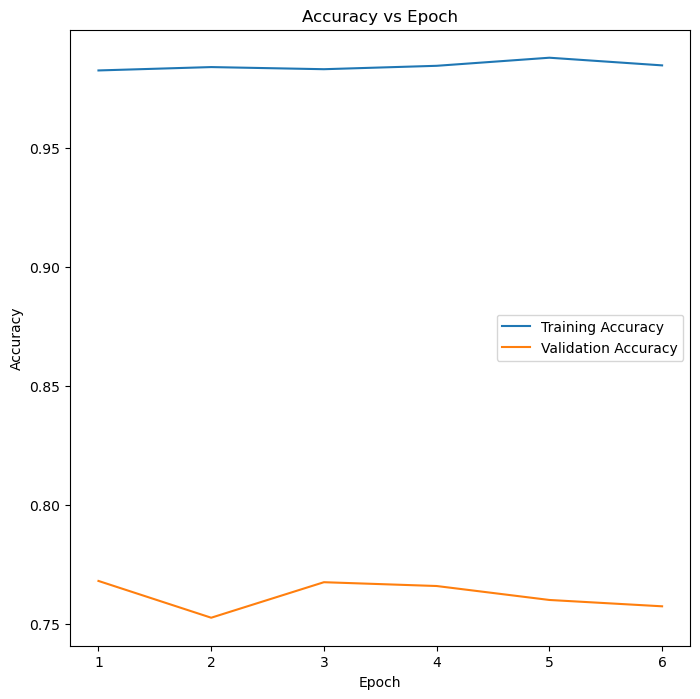

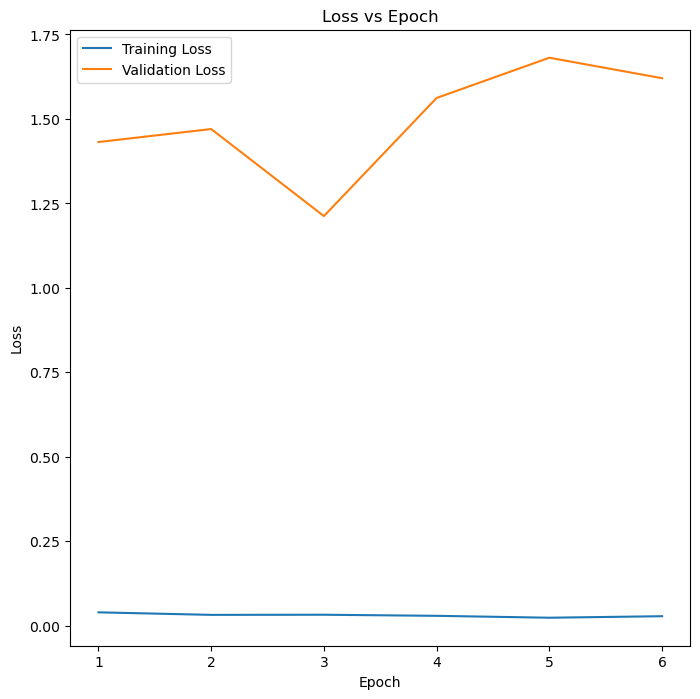

In [259]:
#Plot accuracy vs epoch
train_acc = history_LSTM.history['accuracy']
val_acc = history_LSTM.history['val_accuracy']
epoch_=[1,2,3,4,5,6]

plt.figure(figsize=(8, 8))
plt.plot(epoch_,train_acc, label="Training Accuracy")
plt.plot(epoch_,val_acc, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

#Plot loss vs epoch
train_loss = history_LSTM.history['loss']
val_loss = history_LSTM.history['val_loss']

plt.figure(figsize=(8, 8))
plt.plot(epoch_,train_loss, label="Training Loss")
plt.plot(epoch_,val_loss, label="Validation Loss")
plt.legend()
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

We see that the model's validation accuracy peaked at epoch 3. This is also where the validation loss is the lowest. After epoch 3, validation accuracy starts decreasing and loss increasing. This suggests that the model starts to overfit the training data after epoch 3.

Therefore, the model stops training at epoch 6 and restores the weights from epoch 3.

Let's look at other accuracy metrics.

59/59 [==============================] - 4s 39ms/step


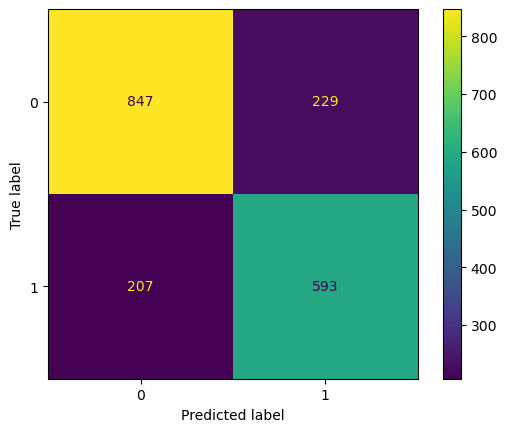

In [237]:
#Predict the test set
y_pred_LSTM=model_LSTM.predict(X_val)
y_pred_LSTM=(y_pred_LSTM > 0.5).astype(int).flatten()

#Confusion matrix
cm=confusion_matrix(y_val.flatten(),y_pred_LSTM)
ConfusionMatrixDisplay(cm).plot()

In [238]:
# Accuracy metrics
acc_LSTM=accuracy_score(y_val.flatten(),y_pred_LSTM)
recall_LSTM=recall_score(y_val.flatten(),y_pred_LSTM)
precision_LSTM=precision_score(y_val.flatten(),y_pred_LSTM)
f1_LSTM=f1_score(y_val.flatten(),y_pred_LSTM)

print('Accuracy = '+"{:.3f}".format(acc_LSTM))
print('Recall = '+"{:.3f}".format(recall_LSTM))
print('Precision = '+"{:.3f}".format(precision_LSTM))
print('f1 = '+"{:.3f}".format(f1_LSTM))

Accuracy = 0.768
Recall = 0.741
Precision = 0.721
f1 = 0.731


The accuracy of the model has increased compared to the simple RNN model. f1 score is also higher, suggesting a better balance between recall and precision. This model can predict witha a higher accuracy.

Therefore, of the 2 models, LSTM seems to have a better performance. Next, let's try to improve this LSTM model by changing hyperparamters and model architecture.

## Improved LSTM

### Building Model

In an attempt to improve the LSTM model, I will add another dense layer after LSTM layer. This dense layer has relu activation function. I also add another drop out layer after the dense layer with masking rate of 0.5. This addition will hopefully help the model identifies groups of words that are more closely associated with the targets.

In [242]:
# Improve LSTM Model
model_LSTM1 = Sequential([
    Embedding(input_dim = 10000, output_dim = 128,input_length=30),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.25),
    Dense(512,activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')])

#Summary
model_LSTM1.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 30, 128)           1280000   
                                                                 
 bidirectional_14 (Bidirecti  (None, 256)              263168    
 onal)                                                           
                                                                 
 dropout_19 (Dropout)        (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 512)               131584    
                                                                 
 dropout_20 (Dropout)        (None, 512)               0         
                                                                 
 dense_20 (Dense)            (None, 1)                 513       
                                                     

### Training model

I have played with changing the optimizer and initial learning rate but the adam optimizer and learning rate of 0.0001 is still the best performing.

In [243]:
# Compile the model
model_LSTM1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Early stopping
ES = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Batch_size=32

# Train the model
history_LSTM1 = model_LSTM1.fit(
    X_train,
    y_train,
    batch_size=Batch_size,
    steps_per_epoch=X_train.shape[0] // Batch_size,
    validation_data=(X_val,y_val),
    epochs=10,
    callbacks=[ES])

Epoch 1/10
175/175 [==============================] - 36s 176ms/step - loss: 0.5366 - accuracy: 0.7318 - val_loss: 0.4429 - val_accuracy: 0.8065
Epoch 2/10
175/175 [==============================] - 29s 166ms/step - loss: 0.2997 - accuracy: 0.8790 - val_loss: 0.5178 - val_accuracy: 0.7964
Epoch 3/10
175/175 [==============================] - 24s 137ms/step - loss: 0.1935 - accuracy: 0.9260 - val_loss: 0.6880 - val_accuracy: 0.7836
Epoch 4/10
175/175 [==============================] - 33s 188ms/step - loss: 0.1180 - accuracy: 0.9582 - val_loss: 0.7920 - val_accuracy: 0.7809


### Results



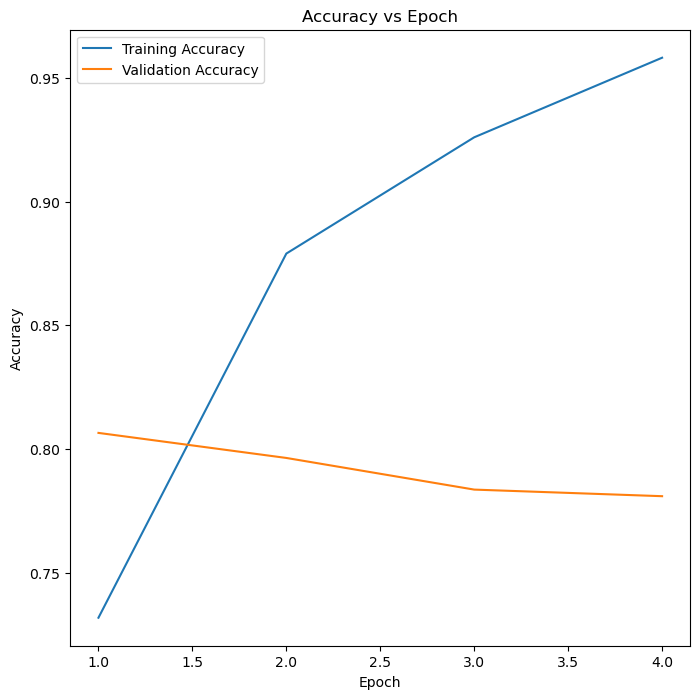

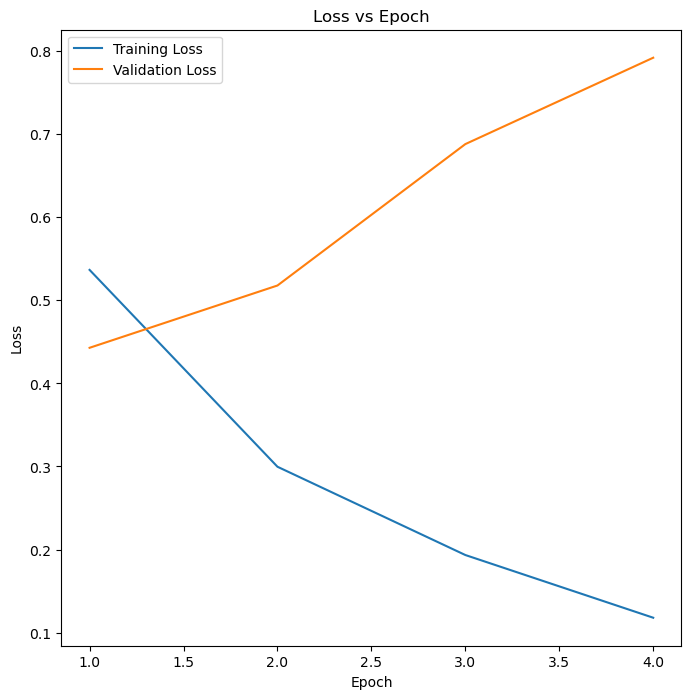

In [260]:
#Plot accuracy vs epoch
train_acc = history_LSTM1.history['accuracy']
val_acc = history_LSTM1.history['val_accuracy']
epoch_=[1,2,3,4]

plt.figure(figsize=(8, 8))
plt.plot(epoch_,train_acc, label="Training Accuracy")
plt.plot(epoch_,val_acc, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

#Plot loss vs epoch
train_loss = history_LSTM1.history['loss']
val_loss = history_LSTM1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.plot(epoch_,train_loss, label="Training Loss")
plt.plot(epoch_,val_loss, label="Validation Loss")
plt.legend()
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

We see that the model's validation accuracy peaked at epoch 1. This is also where the validation loss is the lowest. After epoch 1, validation accuracy starts decreasing and loss increasing. This suggests that the model starts to overfit the training data after epoch 1.

Therefore, the model stops training at epoch 4 and restores the weights from epoch 1.

Let's look at other accuracy metrics.

59/59 [==============================] - 6s 61ms/step


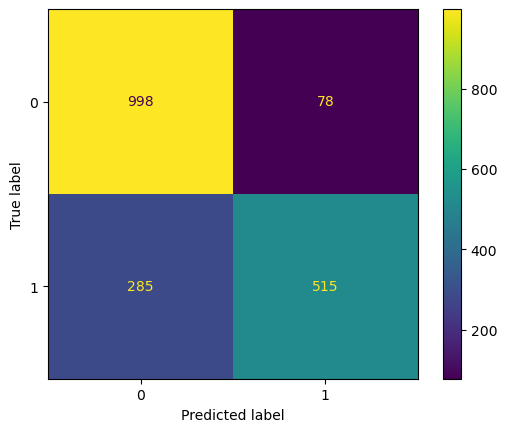

In [244]:
#Predict the test set
y_pred_LSTM1=model_LSTM1.predict(X_val)
y_pred_LSTM1=(y_pred_LSTM1 > 0.5).astype(int).flatten()

#Confusion matrix
cm=confusion_matrix(y_val.flatten(),y_pred_LSTM1)
ConfusionMatrixDisplay(cm).plot()

In [245]:
# Accuracy metrics
acc_LSTM1=accuracy_score(y_val.flatten(),y_pred_LSTM1)
recall_LSTM1=recall_score(y_val.flatten(),y_pred_LSTM1)
precision_LSTM1=precision_score(y_val.flatten(),y_pred_LSTM1)
f1_LSTM1=f1_score(y_val.flatten(),y_pred_LSTM1)

print('Accuracy = '+"{:.3f}".format(acc_LSTM1))
print('Recall = '+"{:.3f}".format(recall_LSTM1))
print('Precision = '+"{:.3f}".format(precision_LSTM1))
print('f1 = '+"{:.3f}".format(f1_LSTM1))

Accuracy = 0.807
Recall = 0.644
Precision = 0.868
f1 = 0.739


The model have a higher accuracy than the original LSTM. It also achieves a higher f1 score than the original LSTM. We see that the model can predict disaster tweets better than non disaster. The precision score is much higher than recall.

## Conclusion

Let's compare my 3 models and select the best performing model.

Looking at the accuracy score, the improved LSTM model is the best performing.

Based on the f1 score, the improved LSTM also has the highest f1.

Therefore, the third model is the best performing model of the 3. I will predict the test data with this model to submit to Kaggle competition. 

In this case, we see that LSTM is superior to simple RNN because it can retain both long term and short term memory and update weights slower than RNN.

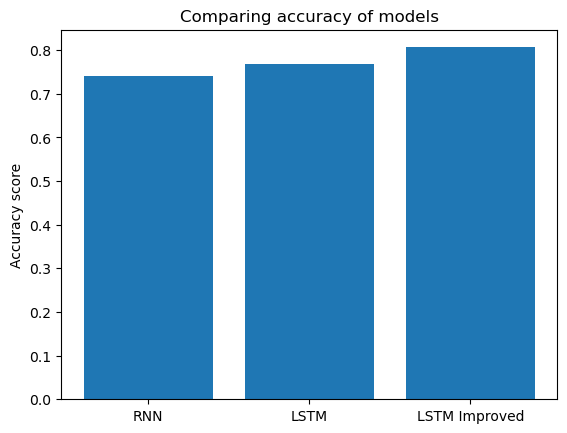

In [254]:
# Compare Accuracy
acc = [acc_RNN, acc_LSTM,acc_LSTM1]

plt.bar(["RNN", "LSTM","LSTM Improved"], acc, capsize=5)
plt.ylabel("Accuracy score")
plt.title("Comparing accuracy of models")
plt.show()

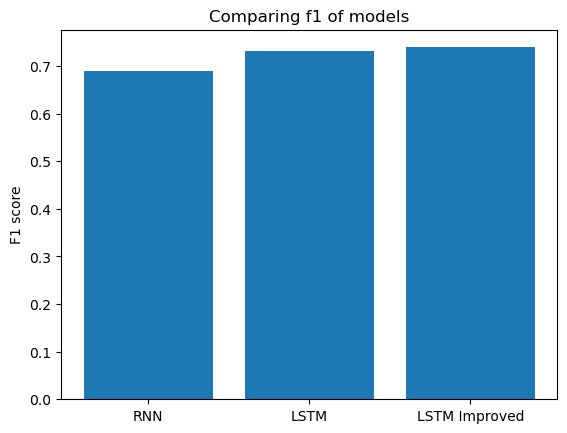

In [256]:
# Compare f1
f1 = [f1_RNN, f1_LSTM, f1_LSTM1]

plt.bar(["RNN", "LSTM","LSTM Improved"], f1, capsize=5)
plt.ylabel("F1 score")
plt.title("Comparing f1 of models")
plt.show()

Let's predict the test data and submit to Kaggle.

In [277]:
# Predict test set
y_test_LSTM1=model_LSTM1.predict(testing_sequences)
y_test_LSTM1=(y_test_LSTM1 > 0.5).astype(int).flatten()

submission_df = pd.DataFrame({
    'id': np.array(test_df['id']),
    'target': y_test_LSTM1})

# Export
submission_df.to_csv('submission.csv', index=False)

102/102 [==============================] - 5s 47ms/step


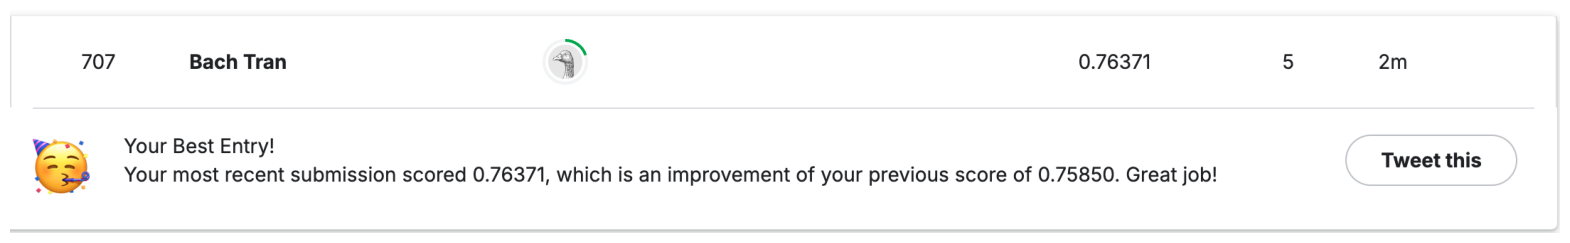

In [279]:
# Show score on Test set
from PIL import Image
img = Image.open('Test_score.png')

plt.figure(figsize=(20, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

I achieved a f1 score of 0.76 with my best performing model. I also rank at 707/863.

There's definitely room for improvement. I think in the future I can try other model architecture like Gated Recurretn Unit. I also think the preprocessing part can play a huge role in the model preformance. I just created my own word dictionary but there are trained tokenizing and embedding models that can group closer words together.